# Classification

Import the libraries necessary to analize data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              197914 non-null  datetime64[ns]
 1   state                             197914 non-null  object        
 2   city_or_county                    197914 non-null  object        
 3   latitude                          197914 non-null  float64       
 4   longitude                         197914 non-null  float64       
 5   congressional_district            197914 non-null  int64         
 6   avg_age_participants              197914 non-null  float64       
 7   n_participants_child              197914 non-null  int64         
 8   n_participants_teen               197914 non-null  int64         
 9   n_females                         197914 non-null  float64       
 10  n_killed                        

In [3]:
#check if there is any null value
df.isnull().values.any()

False

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute involve_killing

In [4]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              197914 non-null  datetime64[ns]
 1   state                             197914 non-null  object        
 2   city_or_county                    197914 non-null  object        
 3   latitude                          197914 non-null  float64       
 4   longitude                         197914 non-null  float64       
 5   congressional_district            197914 non-null  int64         
 6   avg_age_participants              197914 non-null  float64       
 7   n_participants_child              197914 non-null  int64         
 8   n_participants_teen               197914 non-null  int64         
 9   n_females                         197914 non-null  float64       
 10  n_killed                        

In [5]:
col_to_plot = [i for i in list(df.columns) if i not in ['latitude', 'longitude', 'date','state','city_or_county','congressional_district', 'incident_characteristics1']] 

corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
corr_matrix_ind

,avg_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage,...,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_rate,injured_rate,arrested_rate,survival_rate,winning_party_percentage,involve_killing
avg_age_participants,1.000000,-0.170126,-0.264907,0.056132,0.125369,-0.103099,-0.046842,-0.017721,-0.050765,0.025187,...,0.125241,-0.016115,-0.007628,0.006832,0.129706,-0.108528,0.000950,0.002604,-0.035201,0.106594
n_participants_child,-0.170126,1.000000,0.011838,0.140637,0.062697,0.052604,-0.012359,0.107527,0.127849,0.031875,...,0.035070,0.028663,-0.011858,0.058695,0.011366,0.019232,-0.042573,0.044215,0.005721,0.020203
n_participants_teen,-0.264907,0.011838,1.000000,0.116213,0.024424,0.113431,0.201504,0.077144,0.272564,0.013818,...,0.005867,0.047771,0.117870,0.036123,-0.032123,0.023717,0.068026,0.008570,0.005820,0.011231
n_females,0.056132,0.140637,0.116213,1.000000,0.185931,0.167039,0.177057,0.179389,0.434541,0.052085,...,0.122539,0.084172,0.102010,0.103855,0.042769,-0.005057,0.009650,0.071297,0.004483,0.099794
n_killed,0.125369,0.062697,0.024424,0.185931,1.000000,-0.175072,-0.035045,-0.103986,0.224388,0.067164,...,0.638774,-0.086310,-0.015194,-0.062491,0.857462,-0.283103,-0.146527,-0.137120,0.033909,0.921258
n_injured,-0.103099,0.052604,0.113431,0.167039,-0.175072,1.000000,-0.134597,-0.038288,0.364839,-0.004623,...,-0.129758,0.479456,-0.097062,-0.040143,-0.259336,0.781449,-0.257068,-0.100742,0.077461,-0.206716
n_arrested,-0.046842,-0.012359,0.201504,0.177057,-0.035045,-0.134597,1.000000,-0.156072,0.462429,-0.035502,...,-0.013620,-0.027844,0.615843,-0.090382,-0.134321,-0.246181,0.742453,-0.197970,-0.070322,-0.031577
n_unharmed,-0.017721,0.107527,0.077144,0.179389,-0.103986,-0.038288,-0.156072,1.000000,0.500518,0.099735,...,-0.076293,-0.014636,-0.115454,0.592529,-0.153955,-0.165567,-0.234154,0.820325,0.011862,-0.104352
n_participants,-0.050765,0.127849,0.272564,0.434541,0.224388,0.364839,0.462429,0.500518,1.000000,0.074452,...,0.133251,0.194746,0.261445,0.288799,0.007792,0.011665,0.097064,0.259319,0.021993,0.174642
povertyPercentage,0.025187,0.031875,0.013818,0.052085,0.067164,-0.004623,-0.035502,0.099735,0.074452,1.000000,...,-0.016235,-0.035165,-0.066652,0.010412,0.048048,-0.034775,-0.071052,0.091427,0.043777,0.071052


<Axes: >

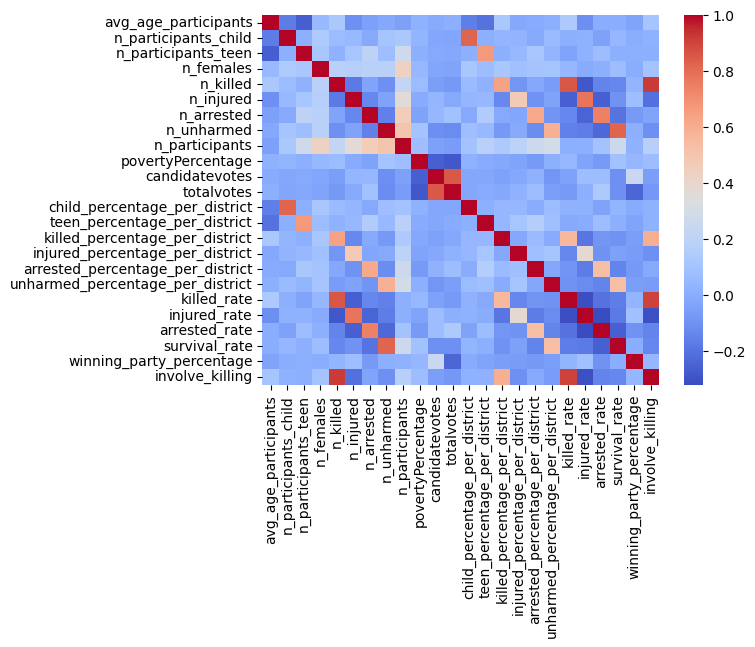

In [6]:
sns.heatmap(corr_matrix_ind, annot=False, cmap='coolwarm')

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [7]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [8]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

In [9]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   latitude                          197914 non-null  float64
 1   longitude                         197914 non-null  float64
 2   congressional_district            197914 non-null  int64  
 3   avg_age_participants              197914 non-null  float64
 4   n_participants_child              197914 non-null  int64  
 5   n_participants_teen               197914 non-null  int64  
 6   n_females                         197914 non-null  float64
 7   n_killed                          197914 non-null  float64
 8   n_injured                         197914 non-null  float64
 9   n_arrested                        197914 non-null  float64
 10  n_unharmed                        197914 non-null  float64
 11  n_participants                    197914 non-null  f

In [10]:
df.drop(columns=['n_killed', 'killed_rate'], axis=1,inplace=True)

We split the dataset into training set and test set, we do a stratified split.

In [11]:
from sklearn.model_selection import train_test_split
label = df.pop('involve_killing')

In [12]:
#percentage of incidents that involve killing over the total number of incidents we consider
#label.sum() / label.count()

In [13]:
train_set, test_set, train_label, test_label = train_test_split(df, label, test_size=0.30, stratify=label)

## Decision tree

We fit the decision tree on our training data.

In [14]:
from sklearn import tree
# possible criteria are 'gini', 'entropy', 'log_loss'
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

This yields the following decision tree.

In [15]:
from IPython.display import Image
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

TODO si potrebbe fare un confronto tra i diversi criteri di splitting:

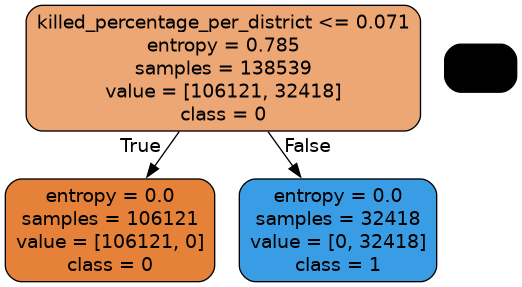

In [ ]:
dt_entropy = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=10, min_samples_split=3, min_samples_leaf=4)
dt_entropy = dt_entropy.fit(train_set, train_label)

from IPython.display import Image
dot_data = tree.export_graphviz(dt_entropy, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

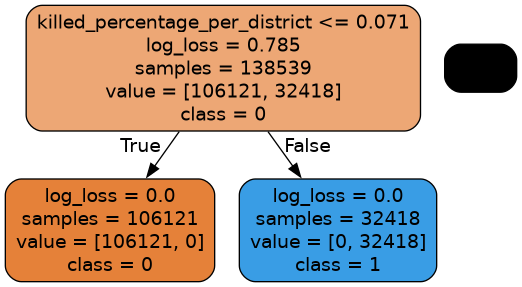

In [ ]:
dt_log = tree.DecisionTreeClassifier(criterion='log_loss', splitter='best', max_depth=10, min_samples_split=3, min_samples_leaf=4)
dt_log = dt_log.fit(train_set, train_label)

from IPython.display import Image
dot_data = tree.export_graphviz(dt_log, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['0', '1'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

The predicted values obtained using the decision tree are then computed.

In [ ]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Evaluation of decision tree

These are the metrics used to evaluate the classification goodness.

In [ ]:
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  1.0
Accuracy test set  1.0
Precision train set  1.0
Recall train set  1.0
F1 score train set  1.0
Support train set  (array([1., 1.]), array([1., 1.]), array([1., 1.]), array([106121,  32418]))


The scores obtained are the following.

In [ ]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45482
           1       1.00      1.00      1.00     13893

    accuracy                           1.00     59375
   macro avg       1.00      1.00      1.00     59375
weighted avg       1.00      1.00      1.00     59375



For cross-validation we print these scores: time for fitting and for scoring and the score obtained in training and test sets.

In [ ]:
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.12246290842692058
Score time  0.009061972300211588
Test score  1.0
Train score  1.0


The following are the values of the confusion matrix.

In [ ]:
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[45482,     0],
       [    0, 13893]])

We plotted the confusion matrix.

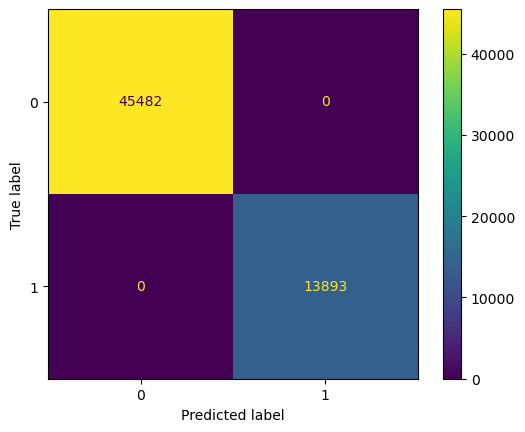

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

We plotted the scatter plot for the classification values on the test set.

In [ ]:
from sklearn.datasets import make_blobs
# TODO sistemare questa riga
#plt.scatter(test_set.iloc[:, 5].values, test_set.iloc[:, 2].values, c=test_label.values, s=25, cmap='YlGn');

## Naive Bayes

Bayes theorem is used to compute the probability of an instance belonging to a given class given some prior knowledge.
We fit the model on our training data.

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

We predict the classes of test set data and evaluate the performance of our classification by computing the scores.

In [ ]:
test_pred_gnb = gnb.predict(test_set)
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     45482
           1       0.86      0.53      0.66     13893

    accuracy                           0.87     59375
   macro avg       0.87      0.75      0.79     59375
weighted avg       0.87      0.87      0.86     59375



We plotted the scatter plot for the classification values on the test set.

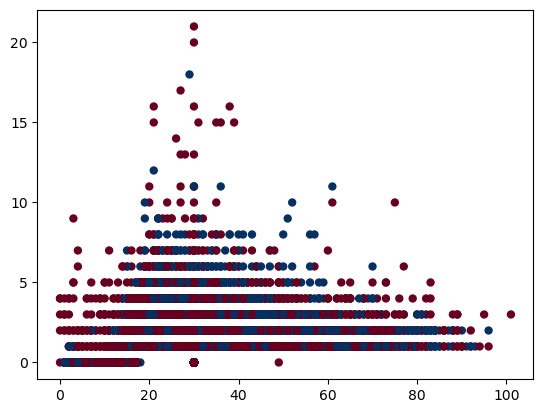

In [ ]:
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_label.values, s=25, cmap='RdBu');

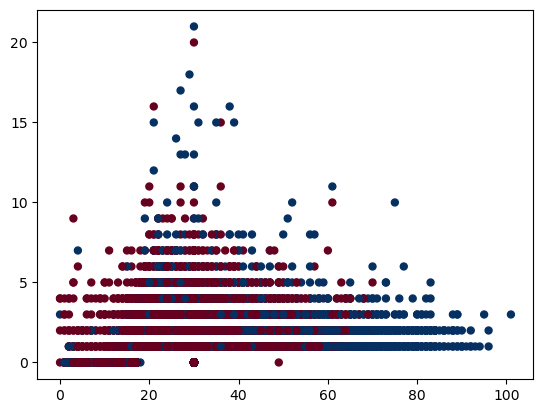

In [ ]:
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_pred_gnb, s=25, cmap='RdBu');

The following are the values of the confusion matrix.

In [ ]:
cm = confusion_matrix(test_label, test_pred_gnb)
cm

array([[44317,  1165],
       [ 6470,  7423]])

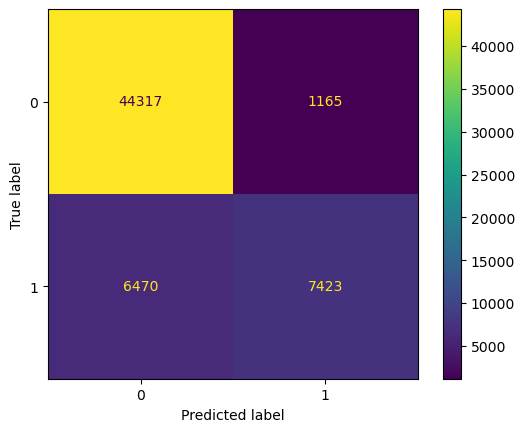

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()
plt.show()

## Random Forest

We define a random forest and fit it on our data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

We predict the classes of test set data and evaluate the performance of our classification by computing the scores.

In [ ]:
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45482
           1       1.00      1.00      1.00     13893

    accuracy                           1.00     59375
   macro avg       1.00      1.00      1.00     59375
weighted avg       1.00      1.00      1.00     59375



### Grid search for parameter setting

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In order to find the best parameters we use a grid search.
The parameters values we want to find are the following.

In [ ]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

We define the number of iterations and we define thn_iter_search = 50e model.

In [ ]:
n_iter_search = 50
clf = RandomForestClassifier(n_estimators=30)

In [ ]:
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))

We print the best values we found for these parameters, along with their means and standard deviation.

In [ ]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

We fit the random forest classifier using the values we found before.

In [ ]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=7,
                             max_depth=5, 
                             min_samples_split=36,
                             min_samples_leaf=15,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

We run the classifier and compute the perfomance scores.

In [ ]:
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45482
           1       1.00      1.00      1.00     13893

    accuracy                           1.00     59375
   macro avg       1.00      1.00      1.00     59375
weighted avg       1.00      1.00      1.00     59375



### Using class weights

We try to improve the results of our classification by assigning weights to the each class.

In [ ]:
class_weights = {0: 0.35, 1:0.65} # TODO potenzialmente da cambiare
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=8,
                             max_depth=6, 
                             min_samples_split=32,
                             min_samples_leaf=10,
                             bootstrap=False,
                             class_weight= class_weights) 
rf = rf.fit(train_set, train_label)

We run the classifier and compute the perfomance scores.

In [ ]:
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45482
           1       1.00      1.00      1.00     13893

    accuracy                           1.00     59375
   macro avg       1.00      1.00      1.00     59375
weighted avg       1.00      1.00      1.00     59375



## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(train_set, train_label)

AdaBoostClassifier()

In [ ]:
test_pred_clf = clf.predict(test_set)
print(classification_report(test_label, 
                            test_pred_clf, 
                            target_names=['<=50', '>50'])) # TODO cambiare

              precision    recall  f1-score   support

        <=50       1.00      1.00      1.00     45482
         >50       1.00      1.00      1.00     13893

    accuracy                           1.00     59375
   macro avg       1.00      1.00      1.00     59375
weighted avg       1.00      1.00      1.00     59375



TODO aggiungere commenti su cosa fa adaboost.
Nel notebook di esempio dice:

Adaboost has many parameters, we can select the base classifier, which can be a DecisionTree, a Logistic Regression and so on, we can select the number of estimators and the learning rate.

In [ ]:
base = tree.DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(train_set, train_label)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=200)

In [ ]:
test_pred_clf = clf.predict(test_set)
print(classification_report(test_label, 
                            test_pred_clf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       1.00      1.00      1.00     45482
         >50       1.00      1.00      1.00     13893

    accuracy                           1.00     59375
   macro avg       1.00      1.00      1.00     59375
weighted avg       1.00      1.00      1.00     59375



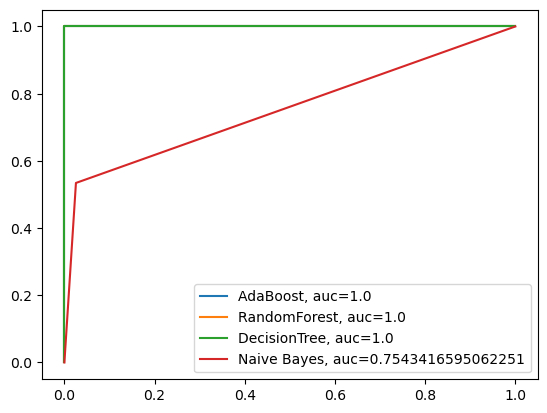

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_clf)
auc = metrics.roc_auc_score(test_label, test_pred_clf)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)

## KNN

KNN works using a distance function, but distance can not be applied to categorical data. We need to handle categorical values, for example we could drop them.

In [ ]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

We define the KNN calssifier by specifying the algorithm and the distance metric to use and we fit it to our data.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#['auto', 'ball_tree', 'kd_tree', 'brute']
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', metric='minkowski').fit(train_set_no_cat, train_label)

We run the prediction and evaluate the performance scores for this model.

In [ ]:
test_pred_knn = knn.predict(test_set_no_cat)
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     45482
           1       0.98      0.78      0.87     13893

    accuracy                           0.94     59375
   macro avg       0.96      0.89      0.92     59375
weighted avg       0.95      0.94      0.94     59375



## SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
# possible kernel values are [linear, poly, rbf, precomputed]
svm.fit(train_set, train_label)

We run the prediction on our test set.

In [ ]:
test_pred_proba_svm = svm.predict_proba(test_set)
test_pred_proba_svm

In [ ]:
test_pred_svm = svm.predict(test_set)
test_pred_svm

We evaluate the performance of our model.

In [ ]:
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['<=50', '>50'])) # TODO  cambiare

We plot the ROC curve in order to estimate the goodness of our classification.

In [ ]:
import scikitplot as skplt
test_pred_proba = svm.predict_proba(test_set)
skplt.metrics.plot_roc(test_label.values, test_pred_proba)
plt.show()

## Rule-based classification

In order to run the RIPPER classifier, we run a grip search to find the best configuration parameter values.
In particular, the prune size defines the grow/prune proportion , while k is the number of optimization runs.

In [ ]:
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)

The best parameter we found are the following.

In [ ]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

We run the model using the configuration found with grid search.

In [ ]:
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='label_num', pos_class=1)

The rules yielded by the RIPPER model are the following.

In [ ]:
ripper.out_model()

We predict the class values using the rules found above.

In [ ]:
ripper.predict(test_set)

In order to evaluate the goodness of this classfication we compute the performance metrics.

In [ ]:
from sklearn.metrics import precision_score, recall_score
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

TODO
with rule based classifiers it is possible to extract the reasons for the prediction.
only for the positive predictions

In [ ]:
ripper.predict(test_set[:15], give_reasons=True)

## Neural Network

We start by considering a neural network composed by one layer.

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 13)),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (22792, 1, 13))
history = model.fit(x_train, y_train,
                    epochs=80,
                    batch_size=512,
                    validation_split=0.2)

In [ ]:
model.summary()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
x_test = np.reshape(test_set.values, (len(test_set), 1, 13))
test_pred_nn = (model.predict(x_test) > 0.5).astype("int32")

In [ ]:
print(test_pred_nn)
print(len(test_pred_nn))
print(len(test_set))

In [ ]:
report_scores(test_label, test_pred_nn)

TODO

Since the first neural network is not performing well, we can modify it, by adding hidden layers and dropout. 

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 13)),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
history = model.fit(x_train, y_train,
                    epochs=80,
                    batch_size=256,
                    validation_split=0.2)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
test_pred_nn = (model.predict(x_test) > 0.5).astype("int32")
test_pred_nn

We compute the performance of the model.

In [ ]:
report_scores(test_label, test_pred_nn)